# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%pip list

In [3]:
import sys, os
module_path = "."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [4]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [5]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [6]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [7]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 4096,
        "stop_sequences": ["\n\nHuman"],
        "temperature": 0,
        "top_k": 0,
        "top_p": 0.0
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f9257472ef0>], client=<botocore.client.BedrockRuntime object at 0x7f9254c6f100>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 4096, 'stop_sequences': ['\n\nHuman'], 'temperature': 0, 'top_k': 0, 'top_p': 0.0}, streaming=True)

### Embedding 모델 선택

In [8]:
from langchain.embeddings import BedrockEmbeddings

In [9]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
)
dimension = 1024 # Titan Embedding V1인 경우 1536 , Titan Embedding V2인 경우 1024
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed) - Optional

In [10]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [11]:
depoly = True

In [12]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

----------!

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Accept: ('application/json',)
ContentType: application/json
Endpoint: huggingface-pytorch-inference-2024-07-09-10-28-14-057


#### Save reranker endpoint to Parameter Store

In [13]:
if depoly:

    import boto3
    from utils.ssm import parameter_store

    region=boto3.Session().region_name
    pm = parameter_store(region)

    pm.put_params(
        key="reranker_endpoint",
        value=f'{predictor.endpoint}',
        overwrite=True,
        enc=False
    )

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Parameter stored successfully.


## 4. Invocation (prediction)

In [14]:
from utils.ssm import parameter_store

In [15]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [16]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7f91f5e20fd0>


In [17]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [18]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [19]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "나는 너를 사랑하지 않아", "text_pair": "나는 너를 좋아하지 않아"},
            {"text": "그는 너를 싫어해", "text_pair": "그는 너를 좋아해"}
        ]
    }
)

In [20]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9984032511711121}, {'label': 'LABEL_0', 'score': 0.004707992542535067}]
CPU times: user 13.4 ms, sys: 315 μs, total: 13.7 ms
Wall time: 683 ms


## 5. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [21]:
import boto3
from utils.ssm import parameter_store

In [22]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [23]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [24]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [25]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: complex-doc-index-21


### OpenSearch Client 생성

In [26]:
from utils.opensearch import opensearch_utils

In [27]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [28]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [29]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    hybrid_search_debugger="None", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=False, # enable parent document
    
    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]

    #rag_fusion=True, # enable rag_fusion
    #query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=False, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [58]:
system_prompt = prompt_repo.get_system_prompt()

In [59]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

관세법상 환급 대상에 대한 직접적인 내용은 제시된 문맥에서 찾을 수 없습니다. 다만, 제시된 내용 중에서 관세 환급과 관련된 부분은 다음과 같습니다.

FTA(자유무역협정)에 따른 관세법의 특례 조항들이 언급되어 있습니다. FTA 협정에 따라 관세 감면 혹은 환급이 이루어질 수 있음을 시사합니다.

또한 역내포괄적경제동반자협정(RCEP)에 따른 특혜관세 적용을 위한 원산지 기준 및 증명 절차가 설명되어 있습니다. 이는 RCEP 회원국 간 무역 시 특혜관세를 받기 위한 요건과 절차를 안내하고 있습니다.

그러나 구체적인 환급 대상, 환급 청구 기한, 환급 청구 방법 등에 대해서는 직접적인 정보가 없습니다. 제시된 문맥만으로는 관세 환급에 대한 질문을 충분히 답변하기 어렵습니다.
-----------------------------------------------
1. Category: Image, Chunk: 107 Characters
-----------------------------------------------


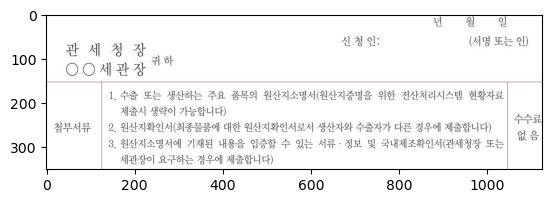

이미지는 관세청장 권한에 대한 설명표를 보여주고 있습니다. 수출입 물품의 원산지 소명, 원산지 확인, 원산지 소명서 기재 내용 확인 등 관세청장의 세 가지 주요 권한 사항을
열거하고 있습니다.
metadata:
 {'img_path': './fig/figure-642-435.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'e9742350-cfb0-4c38-85a7-01ac287036c1', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Category: Image, Chunk: 154 Characters
-----------------------------------------------


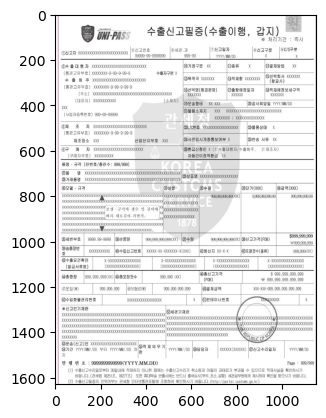

이미지는 수출신고필증(수출이행, 감치)라는 한국 관세청 문서의 양식을 보여주고 있습니다. 이 문서에는 수출업체 정보, 선적 세부사항, 물품 정보, 운송 정보 등 수출과 관련된
다양한 정보가 포함되어 있습니다. 하단에는 관세청의 공인 도장이 찍혀 있어 공식 문서임을 나타냅니다.
metadata:
 {'img_path': './fig/figure-383-288.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'c1aced5e-d6c8-41f2-80c1-31f5a1c1c69a', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: Image, Chunk: 260 Characters
-----------------------------------------------


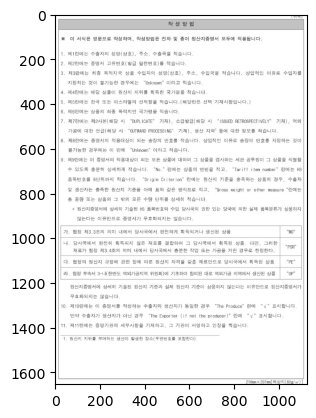

이 이미지는 작성방법에 대한 지침을 제공하고 있습니다. 수출입 신고 시 각 항목별로 어떻게 작성해야 하는지 상세히 안내하고 있습니다. 예를 들어 성명, 주소, 수량 등의 정보를
어떻게 기재해야 하는지, 특정 상황에서는 "Unknown"이나 "DUPLICATE" 등의 키워드를 사용해야 한다고 설명합니다. 또한 HS 품목번호나 원산지 기준 등 작성 시
유의사항도 명시되어 있습니다. 전반적으로 수출입 신고서 작성 방법을 자세히 안내하는 지침서의 내용을 담고 있습니다.
metadata:
 {'img_path': './fig/figure-616-417.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '0919a401-580c-48f0-af2f-47c0347dbecc', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
4. Category: Image, Chunk: 91 Characters
-----------------------------------------------


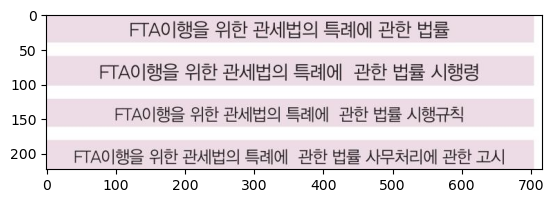

이미지는 FTA(자유무역협정)가 위한 관세법의 특례에 관한 법률 사항들을 나열하고 있습니다. FTA 협정에 따른 관세법의 특례 조항들을 간략하게 설명하고 있습니다.
metadata:
 {'img_path': './fig/figure-482-349.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '9ca7df88-db01-4411-8b22-76134f688d23', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
5. Category: Image, Chunk: 143 Characters
-----------------------------------------------


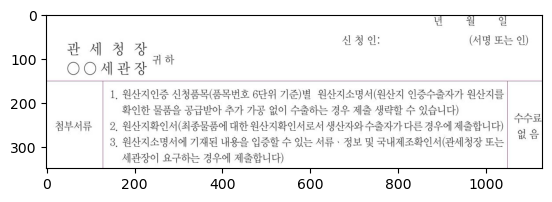

이미지는 원산지증명서 발급 관련 안내문으로 보입니다. 원산지증명서 발급 요건과 절차에 대한 세 가지 사항을 열거하고 있습니다. 원산지 소명자료 제출, 원산지확인기관의 생산공정
확인, 그리고 세관장이 요구하는 경우 제출해야 하는 내용 등을 안내하고 있습니다.
metadata:
 {'img_path': './fig/figure-646-438.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '540ff430-e3b7-47d5-91c0-15fe7f736952', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
6. Category: Image, Chunk: 199 Characters
-----------------------------------------------


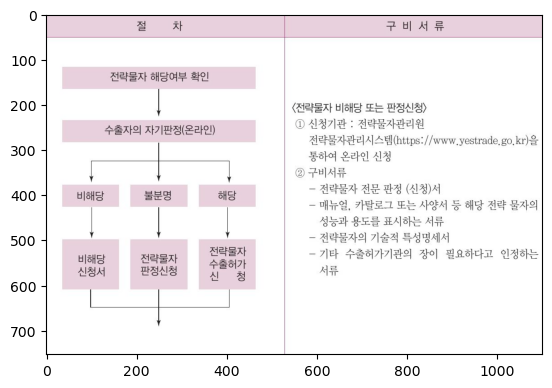

이 이미지는 전략물자 해외반출 허가 절차를 설명하는 흐름도입니다. 전략물자 해외반출 희망 시 수출지원 자기판정(온라인)을 거쳐 비해당, 불분명, 해당으로 나뉩니다. 해당 시에는
전략물자 수출허가 신청서를 제출해야 합니다. 구비서류로는 전략물자 관련 기관의 신고, 전략물자 전문 판정 신청서, 기타 수출허가기관의 장이 필요하다고 인정하는 서류 등이 있습니다.
metadata:
 {'img_path': './fig/figure-239-180.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'eed3592f-1242-443c-98f2-7b895a9049a9', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
7. Category: Image, Chunk: 177 Characters
-----------------------------------------------


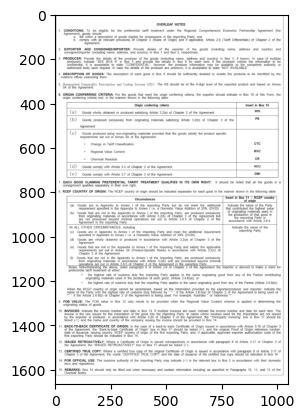

이 이미지는 역내포괄적경제동반자협정(RCEP)에 따른 특혜관세 적용을 위한 상품 원산지 기준 및 증명 절차에 대한 설명입니다. 원산지 기준, 수출입업체 정보 기재 방법, 인보이스
및 원산지증명서 발급 요건 등을 상세히 안내하고 있습니다. 회원국 간 원활한 무역을 위해 필요한 행정절차를 규정하는 내용을 담고 있습니다.
metadata:
 {'img_path': './fig/figure-605-408.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'b6d356fd-b845-4835-82c5-c43748b468af', 'origin_image': '',
'orig_elements': ''}


In [60]:
query = "관세법상 환급 대상에는 어떤것들이 있고, 언제까지 어떻게 청구해야 되는지 알려줘"

response, contexts = qa.invoke(
    query=query,
    verbose=False
)

show_context_used(contexts)

### Parameter updates

In [61]:
opensearch_hybrid_retriever.update_search_params(
    k=7,
    minimum_should_match=0,
    
    # hybird-search debugger
    hybrid_search_debugger="None", #[lexical, semantic, None]
    
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    
    rag_fusion=False, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    
    hyde=False, # enable hyde
    hyde_query=["web_search"], # query type in hyde 
    
    parent_document=False, # enable parent document
    
    # option for complex documents consisting of text, table and image
    complex_doc=True, # False 이면, invocation시 text만 넣는다. 단, 
    
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [71]:
query = "주류의 수출입시 요령에 대해 알려줘. 해당법령에는 뭐가 있는지, 상세 문의를 위한 문의처는 어디인지도 알려줘" # for table

In [72]:
response, contexts = qa.invoke(
    query = query,
    verbose=False
)

주류의 수출입 시 요령에 대해 이 문서에서는 상세히 설명하고 있습니다. 제2항에서 주류의 품목 분류를 "VARIOUS"로 기재하고, 제3항에서 주류의 세부 품목으로 수입자의 요청 시 "AVAILABLE TO CUSTOMS UPON REQUEST"라고 표기할 것을 안내하고 있습니다. 또한 제6항의 표에서 주류 관련 원산지 규정을 "CTC", "RVC", "CTH+RVC" 등으로 구분하여 제시하고 있습니다. 

해당 법령으로는 제3.5조를 언급하고 있으며, 상세 문의를 위한 문의처는 직접적으로 명시되어 있지 않습니다. 다만 이 문서가 수출입신고수수료지가 관더라이오의 협정 제3.17조에 따른 것임을 고려할 때, 관세청이나 관련 협회에 문의하는 것이 적절할 것으로 보입니다.

##################################
query:  주류의 수출입시 요령에 대해 알려줘. 해당법령에는 뭐가 있는지, 상세 문의를 위한 문의처는 어디인지도 알려줘
##################################


### Answer ###
주류의 수출입 시 요령에 대해 이 문서에서는 상세히 설명하고 있습니다. 제2항에서 주류의 품목 분류를 "VARIOUS"로 기재하고, 제3항에서 주류의 세부 품목으로 수입자의 요청
시 "AVAILABLE TO CUSTOMS UPON REQUEST"라고 표기할 것을 안내하고 있습니다. 또한 제6항의 표에서 주류 관련 원산지 규정을 "CTC", "RVC",
"CTH+RVC" 등으로 구분하여 제시하고 있습니다.

해당 법령으로는 제3.5조를 언급하고 있으며, 상세 문의를 위한 문의처는 직접적으로 명시되어 있지 않습니다. 다만 이 문서가 수출입신고수수료지가 관더라이오의 협정 제3.17조에
따른 것임을 고려할 때, 관세청이나 관련 협회에 문의하는 것이 적절할 것으로 보입니다.


### Contexts ###

-----------------------------------------------
1. Category: Image, Chunk: 190 Characters
-----------------------------------------------


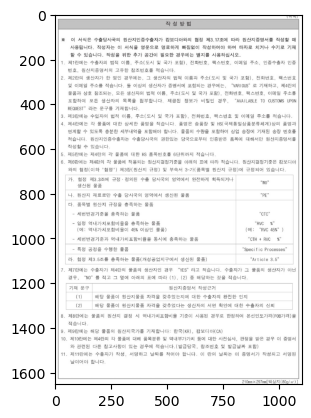

이 이미지는 작성 방법에 대한 설명을 제공하고 있습니다. 수출입 신고 시 필요한 정보와 절차를 11개 항목으로 나누어 상세히 설명하고 있습니다. 수출입 신고 시 필요한 서류와
정보, 특정 상황에서의 처리 방법, 관련 규정 등을 포함하고 있습니다. 전반적으로 수출입 신고 절차를 이해하는 데 도움이 되는 자세한 가이드라인을 제시하고 있습니다.
metadata:
 {'img_path': './fig/figure-624-423.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '80666d7c-b000-4f38-9d94-8e3b246532b6', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Category: Image, Chunk: 150 Characters
-----------------------------------------------


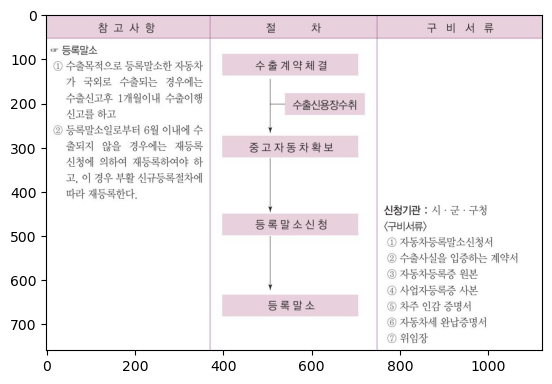

이 이미지는 동물원소 관리 절차를 설명하는 흐름도입니다. 수족관에서 동물을 수용할 때 수족관 내 환경을 점검하고, 수족관 입구에 안내문을 게시하며, 동물 입수 후 신고와 검역
과정을 거치는 것을 보여줍니다. 동물 관리를 위한 주요 단계들을 체계적으로 정리하고 있습니다.
metadata:
 {'img_path': './fig/figure-247-189.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '687ac4dd-566c-483d-855b-db1d6762ef81', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: Image, Chunk: 239 Characters
-----------------------------------------------


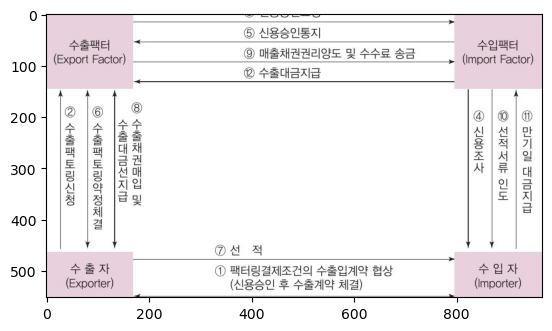

이 이미지는 수출입 과정을 설명하는 다이어그램입니다. 수출업체(Export Factor)와 수입업체(Import Factor) 사이의 과정을 화살표로 표시하고 있습니다. 주요
단계로는 수출대금 지급, 수출통관절차, 선적, 매출채권관리양도 및 수수료 송금, 수입통관절차, 상환, 매입대금지급 등이 있습니다. 또한 수출자(Exporter)와
수입자(Importer) 간의 펀더링 거래조건의 수출입계약 체결 과정도 포함되어 있습니다.
metadata:
 {'img_path': './fig/figure-188-138.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'e891484c-7380-491e-b8c0-c71eafa51a5f', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
4. Category: Image, Chunk: 150 Characters
-----------------------------------------------


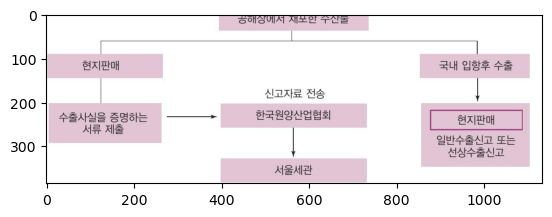

이 이미지는 공해상에서 체포한 수산물 처리 과정을 나타내는 흐름도입니다. 한지판매, 수출사실을 증명하는 서류 제출, 한국원양산업협회, 서울세관 등의 단계를 거쳐 국내 인렸을
수출하는 절차를 보여줍니다. 공해상에서 체포된 수산물의 합법적인 처리 과정을 요약하고 있습니다.
metadata:
 {'img_path': './fig/figure-381-286.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '59777dd9-1d52-426c-9d53-d641998f03fc', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
5. Category: Image, Chunk: 174 Characters
-----------------------------------------------


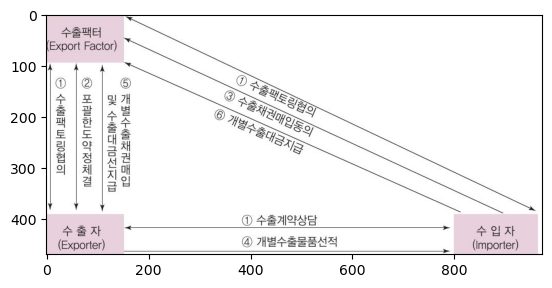

이 이미지는 수출 과정을 설명하는 다이어그램입니다. 수출업체에서 시작하여 수출대리점, 개별수출품선적, 수출개상사, 수출제품의 수송계약, 개별수출대금지급, 미수출대금회수 등의 단계를
거쳐 최종적으로 수입업체에 도달하는 과정을 보여줍니다. 수출 요인으로는 수출품 인정, 모델 및 디자인, 기술수출제한 등이 있습니다.
metadata:
 {'img_path': './fig/figure-188-137.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'abd1e763-0ab9-431b-9825-773c5c29d182', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
6. Category: Image, Chunk: 213 Characters
-----------------------------------------------


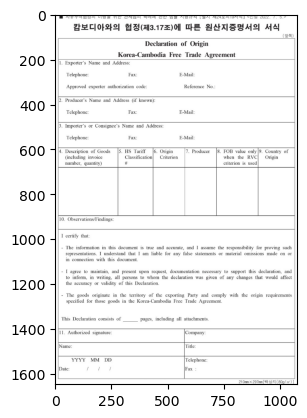

이 이미지는 한국-캄보디아 자유무역협정에 따른 원산지증명서의 양식을 보여주고 있습니다. 이 양식에는 수출업체, 생산업체, 수입업체의 정보를 기재하는 란과 물품 설명, 관세율번호,
원산지 기준, 생산자, FOB 가격, 원산지 국가 등을 기입하는 란이 있습니다. 또한 원산지 요건 준수, 정보 정확성에 대한 확인 문구와 서명란이 있어 원산지 증명을 위한 필수
정보를 포함하고 있습니다.
metadata:
 {'img_path': './fig/figure-623-421.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'bbd8ede8-f6a6-4c8c-81f0-2b3080fd23c9', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
7. Category: Image, Chunk: 136 Characters
-----------------------------------------------


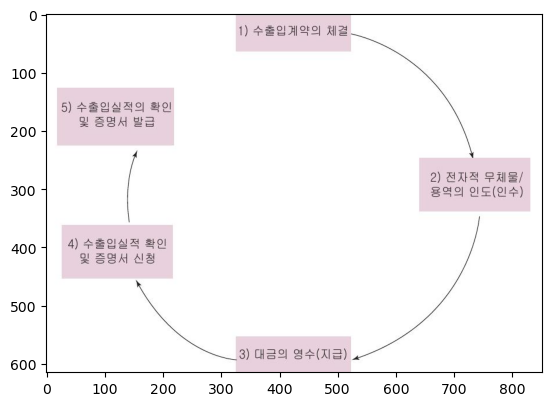

이 이미지는 수출입 과정의 순환 구조를 보여주고 있습니다. 수출입계약의 체결, 선적서류 발급, 대금의 영수, 물품의 인도 등 5가지 주요 단계가 원형 순환 구조로 표현되어
있습니다. 이를 통해 수출입 업무의 전체적인 흐름을 이해할 수 있습니다.
metadata:
 {'img_path': './fig/figure-70-45.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'd5502f97-406a-46de-9cfe-e3e4e079d10e', 'origin_image': '',
'orig_elements': ''}


In [73]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)

### Multi-turn using chat history

In [38]:
from utils.chat import chat_utils
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

#### Momory setting and Save query and response as chat history

In [39]:
memory = chat_utils.get_memory(
    memory_type="ConversationBufferMemory",
    memory_key="chat_history"
)

history = memory.load_memory_variables({})["chat_history"]

In [40]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [41]:
print('memory: ', history)

memory:  [HumanMessage(content='포페이팅 방식과 팩토링 방식의 수출입 차이점에 대해 상세히 알려줘.'), AIMessage(content='이 이미지는 포페이팅(Forfaiting) 방식과 팩토링(Factoring) 방식의 수출입 거래 과정을 보여주고 있습니다. \n\n포페이팅 방식은 수출업체가 수출대금을 받기 위해 은행 등 금융기관에 매출채권을 양도하는 방식입니다. 수출업체는 금융기관으로부터 선지급금을 받고, 금융기관은 나중에 수입업체로부터 대금을 회수합니다. 이 과정에서 수출업체는 신용위험을 제거할 수 있습니다.\n\n반면 팩토링 방식은 수출업체가 매출채권을 팩터링 회사에 양도하고, 팩터링 회사가 수입업체로부터 대금을 회수하는 방식입니다. 팩터링 회사는 수출업체에 선지급금을 지급하고 수수료를 받습니다. 이 방식에서는 수출업체가 신용위험을 부담하지 않습니다.\n\n두 방식 모두 수출업체가 매출채권을 제3자에게 양도하여 조기에 자금을 회수하는 점은 유사하지만, 포페이팅은 금융기관이 관여하고 팩토링은 전문 팩터링 회사가 관여한다는 차이가 있습니다. 또한 포페이팅은 무역금융의 성격이 강하고, 팩토링은 수출업체의 매출채권 관리에 초점이 맞춰져 있습니다.')]


#### Rephrase quetions based on chat hostory 

In [50]:
human_prompt = """
               Here is the question: <question>{question}</question>
               Write in Korean.
               """
               
system_prompt = prompt_repo.get_contextualize_system_prompt()
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [51]:
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        MessagesPlaceholder("chat_history"),
        human_message_template
    ]
)

In [52]:
chain = contextualize_q_prompt | llm_text | StrOutputParser()

In [53]:
#query = "첫 번째 답에서 각 사례, 유형은 뭐가 있어?"
query = "관세법상 환급 대상에는 어떤것들이 있고, 언제까지 어떻게 청구해야 되는지 알려줘"

history = memory.load_memory_variables({})["chat_history"]
print('memory: ', history)
revised_question = chain.invoke(
    {
        "chat_history": history,
        "question": query,
    }
)
revised_question = revised_question.replace("<result>", "").replace("</result>", "")
print ("=============")
print (f'revised_question: {revised_question}')

memory:  [HumanMessage(content='포페이팅 방식과 팩토링 방식의 수출입 차이점에 대해 상세히 알려줘.'), AIMessage(content='이 이미지는 포페이팅(Forfaiting) 방식과 팩토링(Factoring) 방식의 수출입 거래 과정을 보여주고 있습니다. \n\n포페이팅 방식은 수출업체가 수출대금을 받기 위해 은행 등 금융기관에 매출채권을 양도하는 방식입니다. 수출업체는 금융기관으로부터 선지급금을 받고, 금융기관은 나중에 수입업체로부터 대금을 회수합니다. 이 과정에서 수출업체는 신용위험을 제거할 수 있습니다.\n\n반면 팩토링 방식은 수출업체가 매출채권을 팩터링 회사에 양도하고, 팩터링 회사가 수입업체로부터 대금을 회수하는 방식입니다. 팩터링 회사는 수출업체에 선지급금을 지급하고 수수료를 받습니다. 이 방식에서는 수출업체가 신용위험을 부담하지 않습니다.\n\n두 방식 모두 수출업체가 매출채권을 제3자에게 양도하여 조기에 자금을 회수하는 점은 유사하지만, 포페이팅은 금융기관이 관여하고 팩토링은 전문 팩터링 회사가 관여한다는 차이가 있습니다. 또한 포페이팅은 무역금융의 성격이 강하고, 팩토링은 수출업체의 매출채권 관리에 초점이 맞춰져 있습니다.'), HumanMessage(content='포페이팅 방식과 팩토링 방식의 수출입 차이점에 대해 상세히 알려줘.'), AIMessage(content='이 이미지에서는 포페이팅과 팩토링 방식에 대한 직접적인 설명이 없습니다. 다만 포페이터(Forfaiter)라는 용어가 언급되어 있어 포페이팅 방식과 관련이 있음을 알 수 있습니다. 포페이팅은 수출업체가 매출채권을 금융기관에 할인하여 조기에 대금을 회수하는 방식입니다. 팩토링은 수출업체가 매출채권을 팩터링 회사에 양도하고 대금을 회수하는 방식입니다. 주요 차이점은 포페이팅은 금융기관이 관여하지만 팩토링은 전문 팩터링 회사가 관여한다는 점입니다. 또한 포페이팅은 일회성 거래이지만 팩토링은 지속적인 거래 관계를 맺습니다.')]
<result>관세법

In [54]:
print (f'revised_question: {revised_question}')

revised_question: 관세법상 환급 대상에 대한 질문을 명확히 하기 위해, 다음과 같은 질문을 할 수 있습니다:

관세 환급 대상에는 어떤 경우들이 포함되며, 환급을 받기 위해서는 어떤 절차를 거쳐야 하고 기한은 어떻게 되는지 자세히 설명해 주시기 바랍니다.


#### Repeat QA and save chat history

In [55]:
response, contexts = qa.invoke(
    query = revised_question,
    verbose=False
)

관세 환급 대상에는 다음과 같은 경우들이 포함됩니다:

1. 수출물품에 대해 납부한 관세를 환급받을 수 있습니다. 수출 후 일정 기간 내에 수출신고필증을 제출하면 이미 납부한 관세를 환급받을 수 있습니다.

2. 원재료를 수입하여 제품을 생산한 후 그 제품을 수출할 경우, 원재료 수입 시 납부한 관세를 환급받을 수 있습니다. 이를 '간접적 수출환급'이라고 합니다.

3. 수입물품을 국내에서 사용하지 않고 재수출할 경우, 수입 시 납부한 관세를 환급받을 수 있습니다.

환급을 받기 위해서는 관련 증빙서류를 구비하여 세관에 환급 신청을 해야 합니다. 환급 신청 기한은 일반적으로 수출일 또는 관세납부일로부터 1년 이내입니다. 세관에서 서류 심사 후 적합할 경우 환급금을 지급합니다.

No relevant contexts

In [56]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [57]:
print('memory: ', history)

memory:  [HumanMessage(content='포페이팅 방식과 팩토링 방식의 수출입 차이점에 대해 상세히 알려줘.'), AIMessage(content='이 이미지는 포페이팅(Forfaiting) 방식과 팩토링(Factoring) 방식의 수출입 거래 과정을 보여주고 있습니다. \n\n포페이팅 방식은 수출업체가 수출대금을 받기 위해 은행 등 금융기관에 매출채권을 양도하는 방식입니다. 수출업체는 금융기관으로부터 선지급금을 받고, 금융기관은 나중에 수입업체로부터 대금을 회수합니다. 이 과정에서 수출업체는 신용위험을 제거할 수 있습니다.\n\n반면 팩토링 방식은 수출업체가 매출채권을 팩터링 회사에 양도하고, 팩터링 회사가 수입업체로부터 대금을 회수하는 방식입니다. 팩터링 회사는 수출업체에 선지급금을 지급하고 수수료를 받습니다. 이 방식에서는 수출업체가 신용위험을 부담하지 않습니다.\n\n두 방식 모두 수출업체가 매출채권을 제3자에게 양도하여 조기에 자금을 회수하는 점은 유사하지만, 포페이팅은 금융기관이 관여하고 팩토링은 전문 팩터링 회사가 관여한다는 차이가 있습니다. 또한 포페이팅은 무역금융의 성격이 강하고, 팩토링은 수출업체의 매출채권 관리에 초점이 맞춰져 있습니다.'), HumanMessage(content='포페이팅 방식과 팩토링 방식의 수출입 차이점에 대해 상세히 알려줘.'), AIMessage(content='이 이미지에서는 포페이팅과 팩토링 방식에 대한 직접적인 설명이 없습니다. 다만 포페이터(Forfaiter)라는 용어가 언급되어 있어 포페이팅 방식과 관련이 있음을 알 수 있습니다. 포페이팅은 수출업체가 매출채권을 금융기관에 할인하여 조기에 대금을 회수하는 방식입니다. 팩토링은 수출업체가 매출채권을 팩터링 회사에 양도하고 대금을 회수하는 방식입니다. 주요 차이점은 포페이팅은 금융기관이 관여하지만 팩토링은 전문 팩터링 회사가 관여한다는 점입니다. 또한 포페이팅은 일회성 거래이지만 팩토링은 지속적인 거래 관계를 맺습니다.'), HumanMessag